## Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import shap
import pickle
%matplotlib inline 

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def set_plotting_style():
    # Set the default style
    sns.set_style("darkgrid")
    
    # Set the size of all parameters
    plt.rcParams['figure.figsize'] = (8, 6)  # Set the figure size
    plt.rcParams['figure.dpi'] = 80  # Set the figure dpi
    plt.rcParams['font.size'] = 12  # Set the font size
    plt.rcParams['legend.fontsize'] = 'medium'  # Set the legend font size
    plt.rcParams['figure.titlesize'] = 'large'  # Set the figure title size
    plt.rcParams['axes.titlesize'] = 'large'  # Set the axes title size
    plt.rcParams['axes.labelsize'] = 'medium'  # Set the axes label size
    plt.rcParams['xtick.labelsize'] = 'medium'  # Set the xticks label size
    plt.rcParams['ytick.labelsize'] = 'medium'  # Set the yticks label size

## Model Engineering

### Data Preprocessing

In [3]:
# Load the cleaned train data
train_cn = pd.read_csv(r"C:\Users\ADMIN\Desktop\ML_Project\ML_Project\datasets\clean\train_cleaned.csv")

# Load the cleaned test data
test_cn = pd.read_csv(r'C:\Users\ADMIN\Desktop\ML_Project\ML_Project\datasets\clean\test_cleaned.csv')

In [4]:
train_cn.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
train_cn.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [6]:
# Define a mapping from sex categories to numbers
mapping = {'male': 0, 'female': 1}

# Map 'sex' column in train set
train_cn['Sex'] = train_cn['Sex'].map(mapping)

# Map 'sex' column in test set
test_cn['Sex'] = test_cn['Sex'].map(mapping)

In [7]:
# Define a mapping from embarked categories to numbers
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}

# Map 'Embarked' column in train set
train_cn['Embarked'] = train_cn['Embarked'].map(embarked_mapping)

# Map 'Embarked' column in test set
test_cn['Embarked'] = test_cn['Embarked'].map(embarked_mapping)
train_cn.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


In [8]:
# Create the StandardScaler object
scaler = StandardScaler()

# Fit StandardScaler on the 'Fare' and 'Age' columns of the train set
scaler.fit(train_cn[['Age', 'Fare']])  

# Transform the 'Fare' and 'Age' columns of the train set
train_cn[['Age', 'Fare']] = scaler.transform(train_cn[['Age', 'Fare']]) 

# Transform the 'Fare' and 'Age' columns of the test set
test_cn[['Age', 'Fare']] = scaler.transform(test_cn[['Age', 'Fare']]) 

In [9]:
# Save the fitted StandardScaler to a pickle file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [10]:
# Prepare the training data
X_train = train_cn.drop('Survived', axis=1)
y_train = train_cn['Survived']

# Prepare the test data
X_test = test_cn.drop('Survived', axis=1)
y_test = test_cn['Survived']

#Train shape
X_train.shape, y_train.shape

((891, 7), (891,))

In [11]:
#Test set shape
X_test.shape, y_test.shape

((418, 7), (418,))

### Feature Selection

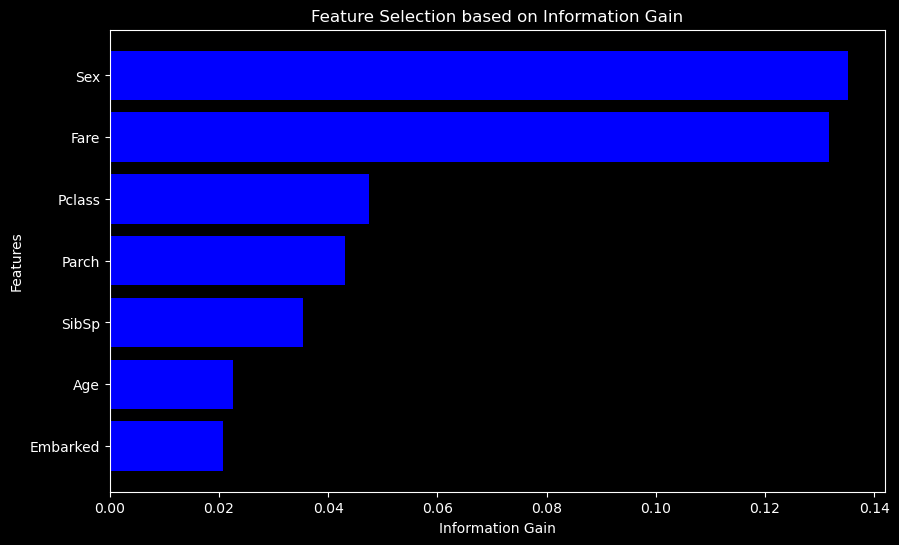

In [12]:
# Compute the mutual information between each feature and the target
mutual_info = mutual_info_classif(X_train, y_train)

# Create a DataFrame of features and their mutual information
info_gain_df = pd.DataFrame({'Feature': X_train.columns, 'InfoGain': mutual_info})

# Sort the DataFrame by InfoGain in descending order
info_gain_df = info_gain_df.sort_values('InfoGain', ascending=False)

# Plot the information gain of each feature
plt.figure(figsize=(10, 6))
plt.barh(info_gain_df['Feature'], info_gain_df['InfoGain'], color='b')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.title('Feature Selection based on Information Gain')
plt.gca().invert_yaxis()  # Reverse the order of features
plt.show()

In [13]:
# Select the top 5 features
top_6_features = info_gain_df['Feature'].head(6)

# Filter X_train and X_test to only include the top 5 features
X_train = X_train[top_6_features]
X_test = X_test[top_6_features]

# Select the top 5 features
top_5_features = info_gain_df['Feature'].head(6)

# Filter X_train and X_test to only include the top 5 features
X_train = X_train[top_5_features]
X_test = X_test[top_5_features]

### Modeling

#### Base Model

In [14]:
# Initialize a SMOTE object
smote = SMOTE(random_state=42)

# Resample the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize a KFold object with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a Logistic Regression model
baseline_model = LogisticRegression()

# Perform 5-fold cross-validation on the baseline model
scores = cross_val_score(baseline_model, X_train_res, y_train_res, cv=kf)

# Compute the mean F1 score
baseline_f1_cv = scores.mean()

print("Baseline F1 score (5-fold CV): ", baseline_f1_cv)

# Fit the model to the resampled training data
baseline_model.fit(X_train_res, y_train_res)

# Predict the labels of the test set
y_pred = baseline_model.predict(X_test)

# Compute accuracy of the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred)

print("Baseline accuracy: ", baseline_accuracy)

# Compute F1 score of the baseline model
baseline_f1 = f1_score(y_test, y_pred)

print("Baseline F1 score: ", baseline_f1)

Baseline F1 score (5-fold CV):  0.787766708177667
Baseline accuracy:  0.9066985645933014
Baseline F1 score:  0.8828828828828829


In [15]:
# Define a function to create a pipeline for each model
def make_pipeline(model):
    return Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

In [16]:
# Define your model
model = make_pipeline(KNeighborsClassifier())

# Define your parameter grid
param_grid = {'model__n_neighbors': range(1, 30),
              'model__weights': ['uniform', 'distance'],
              'model__metric': ['euclidean', 'manhattan'],
              'model__p': [1, 2],
              'model__leaf_size': [10, 20, 30]}

# Define your KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=kfold)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best parameters:  {'model__leaf_size': 10, 'model__metric': 'manhattan', 'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'uniform'}
Best cross-validation score:  0.8103195028560668
F1 Score:  0.8231884057971015


In [17]:
# Define your model
model = make_pipeline(GaussianNB())

# Define your parameter grid
param_grid = {'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Define your KFold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=kfold)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best parameters:  {'model__var_smoothing': 1e-09}
Best cross-validation score:  0.7687640449438202
F1 Score:  0.863095238095238


In [18]:
# Define your model
model = make_pipeline(RandomForestClassifier())

# Define your parameter grid
param_grid = {'model__n_estimators': [50, 100, 200],
              'model__max_depth': [None, 5, 10, 15],
              'model__min_samples_split': [2, 5, 10],
              'model__min_samples_leaf': [1, 2, 4],
              'model__bootstrap': [True, False],
              'model__criterion': ['gini', 'entropy']}

# Define your KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=kfold)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best parameters:  {'model__bootstrap': True, 'model__criterion': 'gini', 'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best cross-validation score:  0.8339150084740442
F1 Score:  0.7987012987012987


In [20]:
# Define your model
model = make_pipeline(GradientBoostingClassifier())

# Define your parameter grid
param_grid = {'model__n_estimators': [10, 50, 100, 200], 
              'model__learning_rate': [0.001, 0.01, 0.1, 1], 
              'model__max_depth': [3, 4, 5], 
              'model__min_samples_split': [2, 5, 10], 
              'model__min_samples_leaf': [1, 2, 4], 
              'model__subsample': [0.5, 0.7, 1], 
              'model__max_features': ['sqrt', 'log2']}

# Define your KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=kfold)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best parameters:  {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 200, 'model__subsample': 0.5}
Best cross-validation score:  0.8361559224154165
F1 Score:  0.7935483870967742


In [21]:
# Define your model
model = make_pipeline(AdaBoostClassifier())

# Define your parameter grid
param_grid = {'model__n_estimators': [50, 100, 200],
              'model__learning_rate': [0.01, 0.1, 1],
              'model__algorithm': ['SAMME', 'SAMME'],
              'model__estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
              'model__estimator__max_depth': [1, 2]}

# Define your KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=kfold)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best parameters:  {'model__algorithm': 'SAMME', 'model__estimator': DecisionTreeClassifier(max_depth=2), 'model__estimator__max_depth': 2, 'model__learning_rate': 0.1, 'model__n_estimators': 50}
Best cross-validation score:  0.8047078023978408
F1 Score:  0.8955223880597014


In [22]:
# Define your model
model = make_pipeline(DecisionTreeClassifier())

# Define your parameter grid
param_grid = {'model__max_depth': [None, 5, 10, 15],
              'model__min_samples_split': [2, 5, 10],
              'model__min_samples_leaf': [1, 2, 4],
              'model__max_features': ['sqrt', 'log2'],
              'model__criterion': ['gini', 'entropy']}

# Define your KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=kfold)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)



Best parameters:  {'model__criterion': 'gini', 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Best cross-validation score:  0.8092461239093591
F1 Score:  0.7628865979381443


In [23]:
# Define your model
model = make_pipeline(XGBClassifier())

# Define your parameter grid
param_grid = {'model__n_estimators': [50, 100, 200],
              'model__learning_rate': [0.01, 0.1, 1, 10],
              'model__max_depth': [3, 5, 10],
              'model__min_child_weight': [1, 3, 5],
              'model__gamma': [0, 0.1, 0.5],
              'model__subsample': [0.8, 1.0],
              'model__colsample_bytree': [0.8, 1.0]}

# Define your KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=kfold)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best parameters:  {'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__min_child_weight': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best cross-validation score:  0.835044881049526
F1 Score:  0.7820512820512822


In [24]:
#Define your base model
model1 = RandomForestClassifier()
model2 = GradientBoostingClassifier()
model3 = AdaBoostClassifier()

# Define your VotingClassifier model
model = VotingClassifier(estimators=[('rf', model1), ('gb', model2), ('ab', model3)], voting='soft')

# Define your parameter grid
param_grid = {'rf__n_estimators': [50, 100, 200],
              'gb__n_estimators': [50, 100, 200],
              'ab__n_estimators': [50, 100, 200]}

# Define your KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Print the best score
print("Best cross-validation score: ", grid_search.best_score_)

# Predict the labels of the test set
y_pred = grid_search.predict(X_test)

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best parameters:  {'ab__n_estimators': 100, 'gb__n_estimators': 50, 'rf__n_estimators': 100}
Best cross-validation score:  0.8361684765551441
F1 Score:  0.8194444444444444


# Model Interpretability 

The best model is AdaboostClassifier


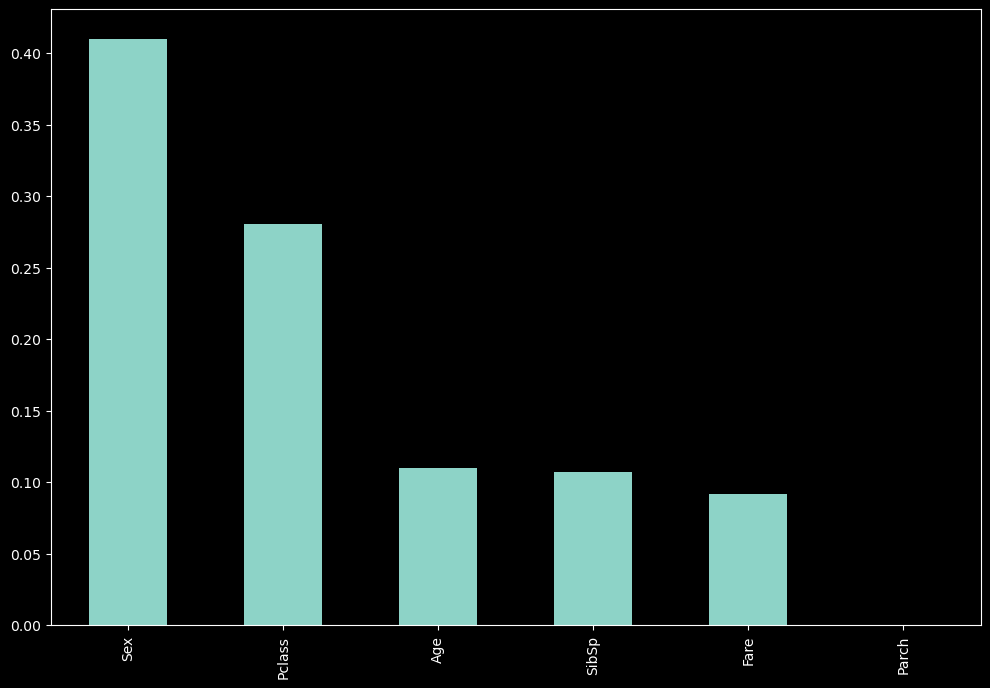

In [14]:
# Initialize a SMOTE object
smote = SMOTE()

# Resample the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize a DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=2)

# Initialize an AdaBoost classifier
best_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=0.1, algorithm='SAMME')

# Fit the model to the resampled training data
best_model.fit(X_train_res, y_train_res)

# Get feature importances
importances = best_model.feature_importances_

# Convert the importances into a one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, X_train.columns)

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

# Make the bar Plot from f_importances 
f_importances.plot(kind='bar', figsize=(12,8))
plt.show()

In [15]:
# Convert the importances into a DataFrame with corresponding df column names as column labels
f_importances = pd.DataFrame(importances.reshape(-1, len(importances)), columns=X_train.columns)

# Sort the DataFrame in descending order of the importances
f_importances = f_importances.sort_values(by=0, axis=1, ascending=False)

print(f_importances)

        Sex    Pclass       Age     SibSp      Fare  Parch
0  0.410071  0.280702  0.110251  0.106934  0.092042    0.0


  0%|          | 0/1098 [00:00<?, ?it/s]

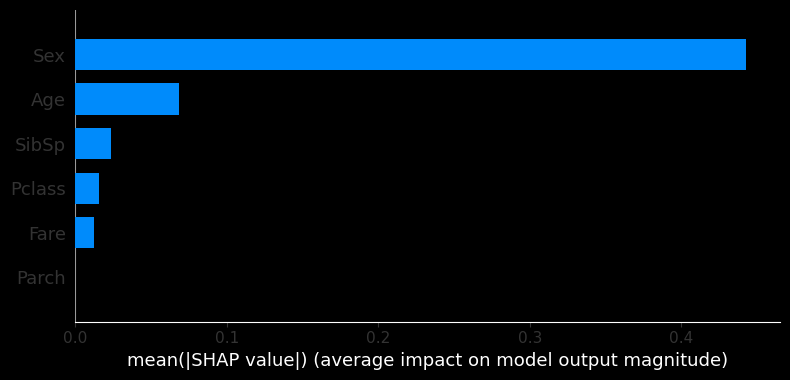

In [16]:
# Use k-means to summarize the dataset
kmeans_summary = shap.kmeans(X_train_res, 100)

# Initialize a KernelExplainer
explainer = shap.KernelExplainer(best_model.predict, kmeans_summary)

# Compute SHAP values
shap_values = explainer.shap_values(X_train_res)

# Plot the SHAP values
shap.summary_plot(shap_values, X_train_res, plot_type="bar")

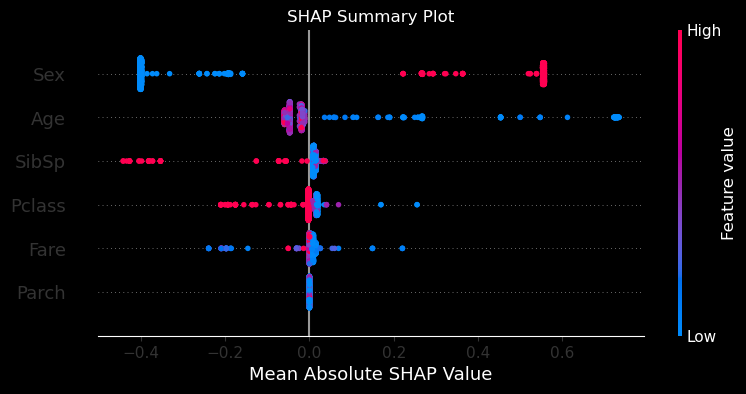

In [17]:
# Set the plot size
plt.figure(figsize=(10, 7))

# Plot the SHAP values with custom settings
shap.summary_plot(shap_values, X_train_res, max_display=10, show=False)

# Set the title
plt.title('SHAP Summary Plot')

# Set the x-label
plt.xlabel('Mean Absolute SHAP Value')

# Show the plot
plt.show()

# Model Retraining using the most important features.

In [19]:
# Selected features
Features = ['Sex','Fare','Pclass','Age','SibSp']
X_train = X_train[Features]
X_test = X_test[Features]

In [20]:
# Initialize a SMOTE object
smote = SMOTE(random_state=42)

# Resample the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize a DecisionTreeClassifier as the base estimator
base_estimator = DecisionTreeClassifier(max_depth=2)

# Initialize an AdaBoost classifier
best_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=0.1, algorithm='SAMME')

# Fit the model to the resampled training data
best_model.fit(X_train_res, y_train_res)

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1)

In [21]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)

print('F1 Score: ', f1)

F1 Score:  0.9581993569131834


The model Performance improved from 89.55% to 95.82% after reducing the feature number.

Reasons why training a machine learning model with fewer features can improve model performance:

1. Avoids overfitting: More features give the model more flexibility to fit the training data, including noise. This leads to overfitting, where the model performs well on the training data but worse on new unseen data. With fewer features, the model generalizes better.

2. Reduces curse of dimensionality: More features increase the dimensionality of the data, exponentially increasing the volume of space that must be modeled. This can make it difficult for many machine learning algorithms to operate effectively without enormous training datasets. Fewer features mitigate this.

3. Improves interpretability: Models with fewer features are easier for humans to intuitively understand and interpret. This is important for trust and practical application of machine learning.

4. Decreases training time: Fewer features means less compute time needed for model training. This allows faster iteration and testing during development.

5. Addresses irrelevant features: Typically many potential input features are irrelevant for predicting the target. Feature selection removes these irrelevant or partially redundant features to improve signal while reducing noise.

In summary, reducing the set of features can significantly boost model performance by making model training and optimization more efficient, enhancing generalization, supporting interpretability, and focusing predictive signal on the most salient attributes. The tradeoff is thoroughly analyzing features to discard only irrelevant ones rather than indiscriminately reducing dimensionality.

In [22]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [23]:
# load the saved model
load_model = pickle.load(open('finalized_model.sav', 'rb'))